In [39]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

def do_rollout_push(env, policy, magnitude, rate, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []


    dtype = torch.float32
    obs = env.reset()
    done = False

    for cur_step in range(num_steps):
        
        if np.random.uniform() < rate:
            force = np.random.randn(2)
            force = (force / np.linalg.norm(force))*magnitude
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
            
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])


        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)


    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_rollout_noise(env, policy, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        

        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


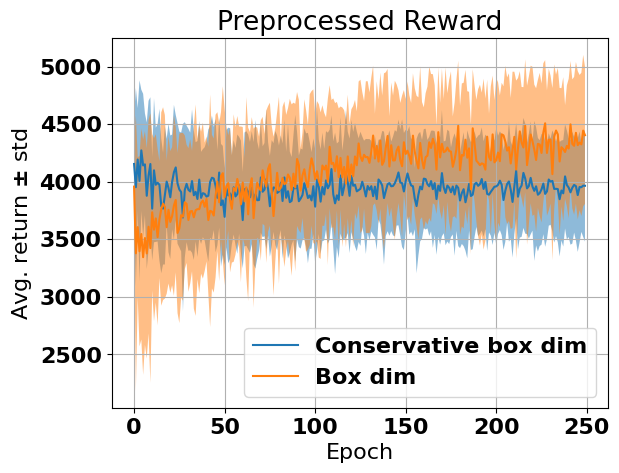

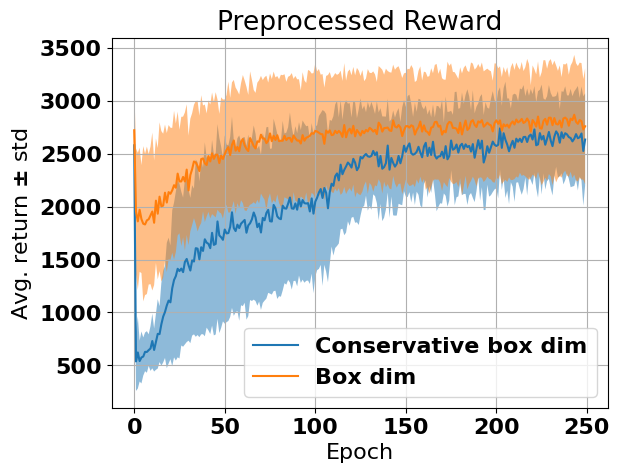

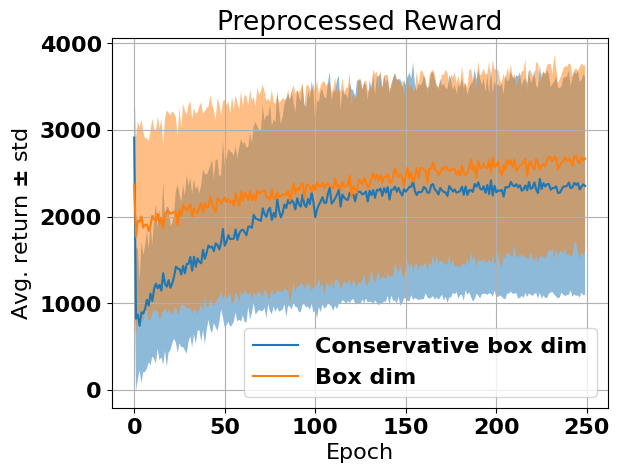

<Figure size 640x480 with 0 Axes>

In [3]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]

matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
init_names = ["identity", "madodiv", "identity"]

for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()


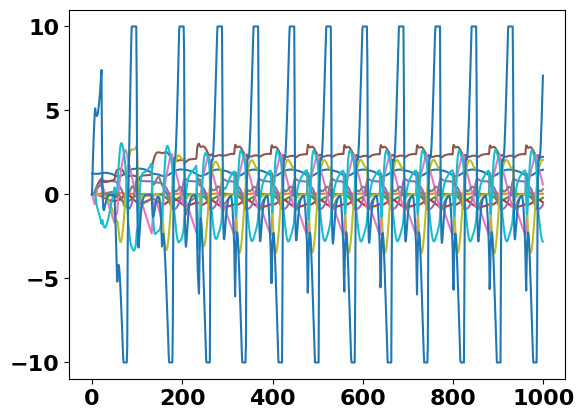

In [37]:
env_name = "Hopper-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']


obs, acts, rews,_ = do_rollout_push(env, policy_dict['identity'][5], magnitude=0, rate=.01)
plt.plot(obs);

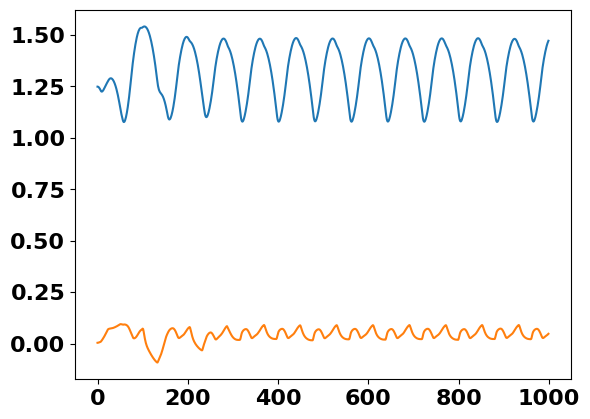

In [38]:
plt.plot(obs[:,0])
plt.plot(obs[:,1])

In [14]:
#===============================
env_name = "Walker2d-v2"
post_names = ['identity', 'mdim_div']
seeds = [0,1,3,4,5,6]
#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
#===============================
# env_name = "Hopper-v2"
# post_names = ['madodiv', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
# ===============================
num_runs = 10
num_preruns = 5

env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

fails = xr.DataArray(np.zeros((2, len(seeds), num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": post_names})

num_steps = 10000

for i_post, post in enumerate(post_names):
    for i_seed, seed in enumerate(seeds):
        pre_x_list = []
        for pre_run in range(num_preruns):
            obs, acts, rews, x_list = do_rollout_push(env, policy_dict[post][seed], magnitude=0, rate=0, num_steps=num_steps, render=False)
            pre_x_list.append(x_list[-1])

        x_target = .85*torch.tensor(pre_x_list).mean()

        for run in range(num_runs):
            obs, acts, rews, x_list = do_rollout_push(env, policy_dict[post][seed], magnitude=5, rate=.2, num_steps=num_steps, render=False)
            if(x_list[-1] < x_target):
                fails[i_post, i_seed, run] = 1
print(f"fail_mean: {fails.mean(dim=('run','seed')).to_dataframe('')}")

fail_mean:              
post         
identity  0.2
mdim_div  0.0


In [28]:
fails.mean(dim=('run')).to_dataframe('')

post     seed     
identity 0     0.6
         1     0.0
         2     0.2
         3     0.0
         4     0.5
         5     0.8
mdim_div 0     0.0
         1     1.0
         2     0.2
         3     0.0
         4     0.0
         5     0.0

In [ ]:
env_name = "Walker2d-v2"
env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']


obs, acts, rews, x_list = do_rollout_noise(env, policy_dict['mdim_div'][1], obs_std=0, act_std=0, render=False)
plt.plot(obs)
plt.figure()
plt.plot(x_list)

x_list[-1]

In [ ]:
env_name = "Ant-v2"
#seeds = [0,1,3,4,5,6,8,9]
seeds = [0,1,2,3,4,5,6,7,8,9]
num_runs = 10
num_preruns = 5
post_names = ['identity', 'mdim_div']

env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']


     
fails = xr.DataArray(np.zeros((2, len(seeds), num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": post_names})

num_steps = 5000

for i_post, post in enumerate(post_names):
    for i_seed, seed in enumerate(seeds):
        pre_x_list = []
        for pre_run in range(num_preruns):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=0, act_std=0, num_steps=num_steps, render=False)
            pre_x_list.append(x_list[-1])

        x_target = .75*torch.tensor(pre_x_list).mean()

        for run in range(num_runs):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=0, act_std=.2, num_steps=num_steps, render=False)
            if(x_list[-1] < x_target):
                fails[i_post, i_seed, run] = 1


In [ ]:
fails.mean(dim=('run')).to_dataframe('')

In [14]:
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,3,4,5,6]
#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']
# seeds = [0,1,2,3,4,5,6,7,8,9]
#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']
seeds = [0,1,2,3,4,5,6,7,8,9]
# ===============================
num_runs = 10
num_preruns = 5


env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']


fails = xr.DataArray(np.zeros((2, len(seeds), num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": post_names})

num_steps = 10000
act_std = 0
obs_std = .010
   
for i_post, post in enumerate(post_names):
    for i_seed, seed in enumerate(seeds):
        pre_x_list = []
        for pre_run in range(num_preruns):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=0, act_std=0, num_steps=num_steps, render=False)
            pre_x_list.append(x_list[-1])

        x_target = .85*torch.tensor(pre_x_list).mean()

        for run in range(num_runs):
            obs, acts, rews, x_list = do_rollout_noise(env, policy_dict[post][seed], obs_std=obs_std, act_std=act_std, num_steps=num_steps, render=False)
            if(x_list[-1] < x_target):
                fails[i_post, i_seed, run] = 1

print(f"fail_mean: {fails.mean(dim=('run','seed')).to_dataframe('')}, noise_std: {act_std}")

fail_mean:               
post          
madodiv   0.20
mdim_div  0.25, noise_std: 0


In [16]:
fails.mean(dim=('run')).to_dataframe('')

post     seed     
madodiv  0     0.5
         1     0.1
         2     0.1
         3     0.1
         4     0.0
         5     0.0
         6     0.7
         7     0.1
         8     0.3
         9     0.1
mdim_div 0     1.0
         1     0.0
         2     0.1
         3     0.0
         4     0.0
         5     0.1
         6     0.0
         7     0.1
         8     1.0
         9     0.2